In [68]:
%matplotlib inline

#***********************************************************
#Inverted Pendulum
#Calculate the optimal feedback gain
#Simulate the motion
#2019/03/01 N. Beppu
#***********************************************************
import math
import numpy
import control
import matplotlib.pyplot as plt

# Physical constant
g = 9.81 # 重力

m = 0.050 # 車輪と車軸の質量[Kg]
R = 0.05 # 車輪の半径[m]
Jw = R * R * m / 2.0 # 車輪と車軸の慣性モーメント[Kg m^2]

M = 0.79 # 本体の質量[Kg]
W = 0.177 # 本体の幅[m]
D = 0.08 # 本体の奥行き[m]
H = 0.140 # 本体の高さ [m]
L = H / 2 # 車軸から本体重心までの距離[m]
D_the = 0.0 # 本体の粘性摩擦係数 [N m s/rad]
D_phi=0.8e-4 # 車軸の粘性摩擦係数 [N m s/rad]
fm = 0.0022
fw = 0
Jpsi = M * L * L / 3.0 # 本体の慣性モーメント[Kg m^2]
Jphi = M * ((W * W) + (D * D)) / 12.0 # body raw interia moment [kg m^2]

# DC Motor Parameters
Jm = 1e-5 # DC motor inertia moment [kg m^2]
Rm = 6.69 # DC motor resistance [Ω]
Kb = 0.468 # DC motor back EMF constant
Kt = 0.317 # DC motor torque constant[N m/A]
n = 1 # gear ratio
 
#===========================================================
#Model parameters
#===========================================================
#-------------------------------------------------
#Tamiya sports tire set
#-------------------------------------------------
#The mass of the wheel (kg)
m_wheel = m
#The radius of the wheel (m)
r_wheel = R
#The moment of inertia of the wheel (kg.m^2)
I_wheel = 0.5 * m_wheel * r_wheel * r_wheel


#-------------------------------------------------
#GearBox
#-------------------------------------------------
gear_ratio = 1.0
 
#-------------------------------------------------
#Whole body
#-------------------------------------------------
#mass (kg)
# m_pendulum = m_gear + m_battery + m_plate + m_circuit
m_pendulum = M
#The moment of inertia (kg.m^2)
# I_pendulum = I_gear + I_battery + I_plate + I_circuit
I_pendulum = Jpsi
#The length between the center of gravity and the axis (m)
r_pendulum = math.sqrt(I_pendulum/m_pendulum)
 
#-------------------------------------------------
#Motor (RE-260RA-2670)
#-------------------------------------------------
#resistance
# Rm = 2.4
Rm = Rm
#The torque constant (N.m/A)
# kt = 0.0018
kt = Kt
#The back electromotive force constant (V.s/rad)
#kb = 0.0022
# kb = 0.0024
kb = Kb
#The mass of rotator (kg)
m_rotator = 0.010
#The radius of rotator (m)
r_rotator = 0.0075
#The moment of inertia of the rotator
Im = Jw
 
#-------------------------------------------------
#parameter summary
#-------------------------------------------------
print("******************************")
print("*        Parameters          *")
print("******************************")
print("Wheel Parameters")
print("m_wheel = " + str(m_wheel) + " (kg)")
print("r_wheel = " + str(r_wheel) + " (m)")
print("I_wheel = " + str(I_wheel) + " (kg.m^2)\n")
 
print("------------------------------")
print("Pendulum Parameters")
print("m_pendulum = " + str(m_pendulum) + " (kg)")
print("r_pendulum = " + str(r_pendulum) + " (m)")
print("I_pendulum = " + str(I_pendulum) + " (kg.m^2)\n")
 
print("------------------------------")
print("Motor Parameters")
print("kt = " + str(kt) + " (N.m/A)")
print("kb = " + str(kb) + " (V.s/rad)")
print("Rm = " + str(Rm) + " (Ohm)")
print("Im = " + str(Im) + "(kg.m^2)")
print("Gear Ratio = " + str(gear_ratio) + "\n")
print("")
 
 
#===========================================================
#Calculate matrix A, B, C (continuous time)
#===========================================================
#-------------------------------------------------
#matrix A (continuous time)
#-------------------------------------------------

E_11 = (2 * m + M) * R * R + 2 * Jw + 2 * n * n * Jm
E_12 = M * L * R - 2 * n * n * Jm
E_21 = E_12
E_22 = M * L * L + Jpsi + 2 * n * n * Jm

E = [\
[E_11, E_12], \
[E_21, E_22] \
]
detE = E[0][0]*E[1][1] - E[0][1]*E[1][0]

alpha = (n*Kt)/Rm
beta = (n*Kt*Kb)/Rm + fm
tmp = beta + fw

A1_32 = -g*M*L* E[0][1]/detE
A1_42 = g*M*L*E[0][0]/detE

A1_33 = -2*((beta+fw)*E[1][1] + beta*E[0][1])/detE

A1_43 = 2*((beta+fw)*E[0][1] + beta*E[0][0])/detE
A1_34 = 2*beta*(E[1][1] + E[0][1])/detE
A1_44 = -2*beta*(E[0][0] + E[0][1])/detE

C = [1, 0, 0, 0]

# 拡大システム A_BAR := 5x5 となる 
A1 = [\
[0,    0,     1,     0], \
[0,    0,     0,     1], \
[0,    A1_32, A1_33, A1_34], \
[0,    A1_42, A1_43, A1_44] \
]

A = [\
[0,    0,     1,     0,     0], \
[0,    0,     0,     1,     0], \
[0,    A1_32, A1_33, A1_34, 0], \
[0,    A1_42, A1_43, A1_44, 0], \
[C[0], C[1],  C[2],  C[3],  0] \
]

A = numpy.array(A)
 
#-------------------------------------------------
#matrix B (continuous time)
#-------------------------------------------------

B1_3 = alpha*(E[1][1] + E[0][1]) / detE
B1_4 = -alpha*(E[0][0] + E[0][1]) / detE

B1 = [\
[0, 0], \
[0, 0], \
[B1_3, B1_3], \
[B1_4, B1_4]\
]

B = [\
[0, 0], \
[0, 0], \
[B1_3, B1_3], \
[B1_4, B1_4], \
[0, 0]
]

B = numpy.array(B)
 
#-------------------------------------------------
#matrix C (continuous time)
#-------------------------------------------------
C1 = [\
[1, 0, 0, 0],\
[0, 1, 0, 0],\
[0, 0, 1, 0],\
[0, 0, 0, 1]\
]

C = [\
[1, 0, 0, 0, 0],\
[0, 1, 0, 0, 0],\
[0, 0, 1, 0, 0],\
[0, 0, 0, 1, 0],\
[0, 0, 0, 0, 1]\
]
C = numpy.array(C)
 
#-------------------------------------------------
#matrix summary (continuous time)
#-------------------------------------------------
print("******************************")
print("*  Matrix (continous time)   *")
print("******************************")
print("Matrix A (continuous time)")
print(A)
print("")
 
print("------------------------------")
print("Matrix B (continuous time)")
print(B)
print("")
 
print("------------------------------")
print("Matrix C (continuous time)")
print(C)
print("\n")
 
 
#===========================================================
#Calculate matrix Ax, Bx, Cx (discrete time)
#===========================================================
#sampling rate of the discrete time system
T = 0.016 #sec
 
#-------------------------------------------------
#matrix Ax (discrete time)
#Ax = I + AT + (AT)^2/2! + ... (5th order approximation)
#-------------------------------------------------
Ax = numpy.zeros( (len(A), len(A[0])) )
temp = numpy.eye(len(A))
for i in range(10):
    Ax = Ax + temp / math.factorial(i)
    temp = numpy.dot(temp, (A*T))
 
#-------------------------------------------------
#matrix Bx (discrete time)
#Bx = {IT + AT^2/2! + A^2T^3/3! + ...}B (5th order approximation)
#-------------------------------------------------
Bx_temp = numpy.eye(len(A)) * T
temp = A * T * T
for i in range(10):
    Bx_temp = Bx_temp + temp / math.factorial(i+2)
    temp = numpy.dot(temp, A*T)
Bx = numpy.dot(Bx_temp, B)
 
#-------------------------------------------------
#matrix Cx (discrete time)
#-------------------------------------------------
Cx = C #the same as continuous time
 
#-------------------------------------------------
#matrix summary (discrete time)
#-------------------------------------------------
print("******************************")
print("*   Matrix (discrete time)   *")
print("******************************")
print("sampling rate = " + str(T) + " sec\n")
 
print("matrix Ax (discrete time)")
print(Ax)
print("")
 
print("matrix Bx (discrete time)")
print(Bx)
print("")
 
print("matrix Cx (discrete time)")
print(Cx)
print("\n")
 
 
#===========================================================
#Calculate the optimal feedback gain
#Quadratic cost function: x^TQx + u^TRu
#discrete time Riccati equation: A^TPA-P-A^TPB(B^TPB+R)^-1B^TPA+Q=0
#===========================================================
#weighting matrix Q
# Q = numpy.array( [\
# [1, 0, 0, 0, 0], \
# [0, 6e5, 0 ,0, 0], \
# [0, 0, 1, 0, 0], \
# [0, 0, 0, 1, 0], \
# [0, 0, 0, 0, 4e2] \
# ])

Q = numpy.array( [\
[1, 0, 0, 0, 0], \
[0, 1, 0 ,0, 0], \
[0, 0, 1, 0, 0], \
[0, 0, 0, 1, 0], \
[0, 0, 0, 0, 1] \
])

#weighting scalar 
# R = 1000.0
R = 1000.0 * numpy.array( [\
[1., 0.], \
[0., 1.] \
])

#calculate the weighting values for the discrete system
Qd = Q * T
Rd = R * T
 
#solve the Discrete-time Algebraic Riccati Equation (DARE)
#P: solution of the Riccati equation
#L: eigenvalues of the closed loop
#G: optimal feedback gain
P, L, G = control.dare(Ax, Bx, Qd, Rd)
# P, L, G = control.care(A, B, Q, R)
print("P")
print(P)
 
print("**********************************")
print("*Solution of the Riccati equation*")
print("**********************************")
 
#calculate Gain: Gain = (B^TPB+R)^-1B^TPA
tran_Bx = Bx.transpose()
BTPB = numpy.dot( numpy.dot(tran_Bx, P), Bx )
temp = numpy.linalg.inv(BTPB + Rd)
Gain = - numpy.dot( numpy.dot( numpy.dot(temp, tran_Bx), P), Ax )
Gain0 = numpy.array( [Gain[0][0], Gain[0][1], Gain[0][2], Gain[0][3], Gain[0][4]] )
GainKf = numpy.array( [\
[Gain[0][0], Gain[0][1], Gain[0][2], Gain[0][3]], \
[Gain[1][0], Gain[1][1], Gain[1][2], Gain[1][3]] \
])
Gain0_4 = numpy.array( [[Gain[0][0], Gain[0][1], Gain[0][2], Gain[0][3]]] )
print("Gain (calculated)")
print(Gain)
print("")
print("Gain (obtained from congtrol.dare)")
print(-G)
print("\n")
 
print("\"gain_motor_angle\"                  : ", -G[0][0], ",")
print("\"gain_gyro_angle\"                   : ", -G[0][1], ",")
print("\"gain_motor_angular_speed\"          : ", -G[0][2], ",")
print("\"gain_gyro_rate\"                    : ", -G[0][3], ",")
print("\"gain_motor_angle_error_accumulated\": ", -G[0][4], ",")
print("\n")
    
#calculate the eigenvalues of the closed loop "Ad - Bd*Gain"
A_BK = Ax + numpy.dot(Bx, Gain)
eigen_value, eigen_vector = numpy.linalg.eig(A_BK)
print("Eigenvalue of the closed loop (calculated)")
for i in eigen_value:
    print(i)
print("")
print("Eigenvalue of the closed loop (obtained from control.dare)")
for i in L:
    print(i)
print("")
 
#check the value of the algebraic Riccati equation
#A^TPA-P-A^TPB(B^TPB+R)^-1B^TPA+Q will be "zero"
temp1 = numpy.dot( numpy.dot(Ax.transpose(), P), Ax )
temp2 = numpy.dot( numpy.dot(Ax.transpose(), P), Bx )
temp3 = numpy.dot( numpy.dot(Bx.transpose(), P), Ax )
temp4 = Rd + numpy.dot( numpy.dot(Bx.transpose(), P), Bx )
temp5 = numpy.dot( temp2, temp3 ) / temp4[0][0]
val = temp1 - temp5 -P +Qd
print("check the value of \"A^TPA-P-A^TPB(B^TPB+R)^-1B^TPA+Q\"")
print("It should be (almost) zero.")
print(val)
print("\n")
 
 


******************************
*        Parameters          *
******************************
Wheel Parameters
m_wheel = 0.05 (kg)
r_wheel = 0.05 (m)
I_wheel = 6.250000000000001e-05 (kg.m^2)

------------------------------
Pendulum Parameters
m_pendulum = 0.79 (kg)
r_pendulum = 0.04041451884327381 (m)
I_pendulum = 0.0012903333333333337 (kg.m^2)

------------------------------
Motor Parameters
kt = 0.317 (N.m/A)
kb = 0.468 (V.s/rad)
Rm = 6.69 (Ohm)
Im = 6.250000000000001e-05(kg.m^2)
Gear Ratio = 1.0


******************************
*  Matrix (continous time)   *
******************************
Matrix A (continuous time)
[[   0.            0.            1.            0.            0.        ]
 [   0.            0.            0.            1.            0.        ]
 [   0.         -313.85172934  -81.44210171   81.44210171    0.        ]
 [   0.          270.97581003   52.55599692  -52.55599692    0.        ]
 [   1.            0.            0.            0.            0.        ]]

--------

In [69]:
#===========================================================
#Simulation
#===========================================================
#initial value
theta_0 = 18 #degree
x = numpy.array( [[theta_0 * math.pi / 180], [0], [0], [0]] )

#total number of the step
num = 300
 
#variables
time = []
theta_array = []
theta_array2 = []
theta_dot_array = []
theta_dot_array2 = []
V_array = []
I_array = []
 
#initialize the lists
time.append(0)
theta_array.append(x[0][0]*180/math.pi) # degree
theta_dot_array.append(x[1][0]*180/math.pi) # degree/sec
theta_array2.append(x[2][0]*r_wheel*100) # cm
theta_dot_array2.append(x[3][0]*r_wheel*100) # cm/sec
 
#calculate the initial value of motor voltage
V_b = 8.28 * 1000
V_max = 0.001089 * V_b - 0.625

print("V_max")
print(V_max)

Vin = numpy.dot(Gain0_4, x)[0][0]
if Vin > V_max:
    Vin = V_max
if Vin < -V_max:
    Vin = -V_max
V_array.append(Vin)
 
#calculate the initial value of motor current
I_array.append( (Vin - kb*x[3][0]*gear_ratio)/Rm )

A_BK = A1 + numpy.dot(B1, GainKf)

print("A_BK")
print(A_BK)

#calculation loop
for i in range(num-1):
    #calculate the next state
    x = numpy.dot( A_BK, x )
 
    #angles, angular rates
    theta_array.append(x[0][0] * 180/math.pi) #degree
    theta_dot_array.append(x[1][0] * 180/math.pi) #degree/s
    theta_array2.append(x[2][0] * r_wheel * 100) #cm
    theta_dot_array2.append(x[3][0] * r_wheel * 100) #cm/s

    #motor voltage
    Vin = numpy.dot(Gain0_4, x)
    if Vin[0][0] > V_max:
        Vin = [[V_max]]
    if Vin[0][0] < -V_max:
        Vin = [[-V_max]]
    V_array.append( Vin[0][0] )
 
    #motor current
    I_array.append( (Vin[0][0] - kb*x[3][0]*gear_ratio)/Rm )
    
    #time
    time.append( T*(i+1) )


V_max
8.391919999999999
A_BK
[[ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 2.25748173e+01  2.80845990e+03  7.95685618e+01  3.52790536e+02]
 [-1.45679201e+01 -1.74390589e+03 -5.13469692e+01 -2.27661835e+02]]


/Users/yoshinori/.local/share/virtualenvs/balanc3r-for-ev3way-et-SkxC7aZY/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in double_scalars
/Users/yoshinori/.local/share/virtualenvs/balanc3r-for-ev3way-et-SkxC7aZY/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in double_scalars
/Users/yoshinori/.local/share/virtualenvs/balanc3r-for-ev3way-et-SkxC7aZY/lib/python3.5/site-packages/ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in double_scalars
/Users/yoshinori/.local/share/virtualenvs/balanc3r-for-ev3way-et-SkxC7aZY/lib/python3.5/site-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in double_scalars


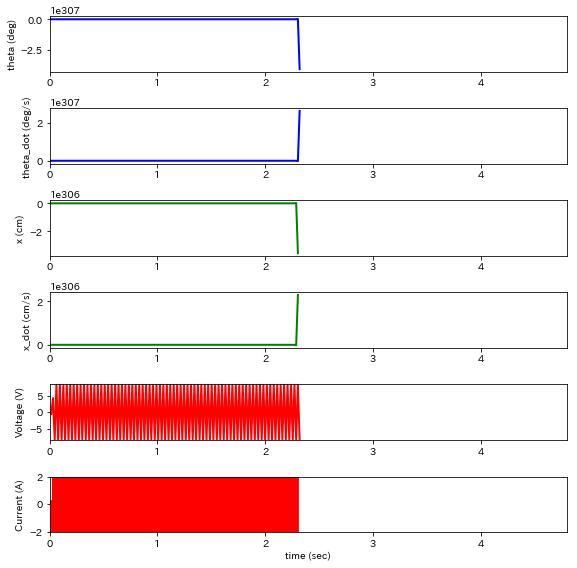

In [70]:
#===========================================================
#Draw graph
#===========================================================
#create figure object
fig = plt.figure( figsize=(8,8) )
 
#use "subplot" to divide the graph area
ax1 = fig.add_subplot(6,1,1)
ax2 = fig.add_subplot(6,1,2)
ax3 = fig.add_subplot(6,1,3)
ax4 = fig.add_subplot(6,1,4)
ax5 = fig.add_subplot(6,1,5)
ax6 = fig.add_subplot(6,1,6)
 
#range of the x axis
stop_time = T * num
 
#angle (degree)
ax1.plot(time, theta_array, color="blue", lw=2)
ax1.set_xlim([0, stop_time])
ax1.set_ylabel("theta (deg)")
 
#angular rate (degree/sec)
ax2.plot(time, theta_dot_array, color="blue", lw=2)
ax2.set_xlim([0, stop_time])
ax2.set_ylabel("theta_dot (deg/s)")
 
#position (cm)
ax3.plot(time, theta_array2, color="green", lw=2)
ax3.set_xlim([0, stop_time])
ax3.set_ylabel("x (cm)")
 
#speed (cm/sec)
ax4.plot(time, theta_dot_array2, color="green", lw=2)
ax4.set_xlim([0, stop_time])
ax4.set_ylabel("x_dot (cm/s)")
 
#voltage (V)
ax5.plot(time, V_array, color="red", lw=2)
ax5.set_ylim([-V_max, V_max])
ax5.set_xlim([0, stop_time])
ax5.set_ylabel("Voltage (V)")
 
#current (A)
ax6.plot(time, I_array, color="red", lw=2)
ax6.set_ylim([-2, 2])
ax6.set_xlim([0, stop_time])
ax6.set_ylabel("Current (A)")
ax6.set_xlabel("time (sec)")
 
#show the graph
plt.tight_layout()
plt.show()

